# [E-09] 폐렴아 기다려라!

이번 프로젝트는 의료영상 기초에 대해서 배우고 의료영상 데이터를 핸들링하는 방법에 대해서 배우는 것을 목표로 한다.

<hr>

## 1. 프로젝트 준비

### 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 변수 설정

In [87]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


<hr>

## 2. 데이터 준비

In [88]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [89]:
# filenames에 train 데이터와 validation 데이터 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames를 8:2로 나눔
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [90]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [91]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [92]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [93]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [94]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [95]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [96]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [97]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [98]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [99]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

<hr>

## 3. 데이터 시각화

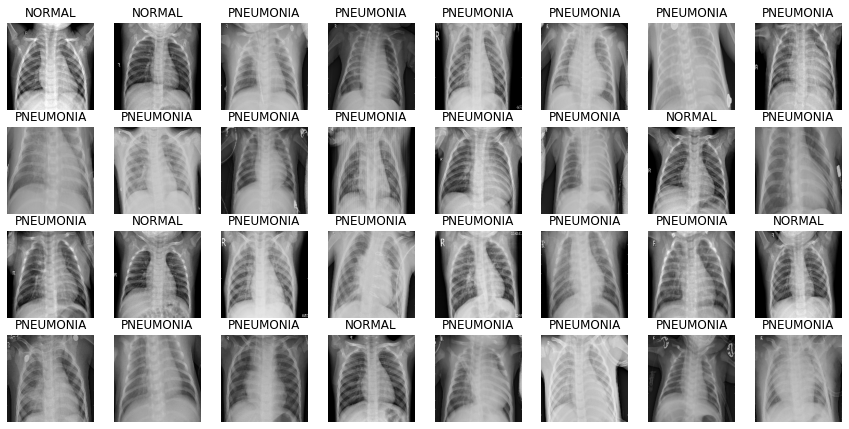

In [100]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

<hr>

## 4. CNN 모델 설계

In [101]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [102]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [103]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리

In [75]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


<hr>

## 5. 모델 훈련

BATCH_SIZE = 16일 때, Accuracy: 77.48

BATCH_SIZE = 32일 때, Accuracy: 83.49

BATCH_SIZE = 64일 때, Accuracy: 79.17

BATCH_SIZE = 32일 때가 Accuracy: 83.49로 가장 성능이 좋게 나왔다. 따라서 BATCH_SIZE는 32로 사용할 예정이다.

In [104]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [105]:
BATCH_SIZE = 32
train_ds._batch_size = BATCH_SIZE
val_ds._batch_size = BATCH_SIZE
test_ds._batch_size = BATCH_SIZE

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/25
130/130 [==============================] - 55s 358ms/step - loss: 0.3999 - accuracy: 0.8505 - precision: 0.9524 - recall: 0.8410 - val_loss: 0.7110 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 373ms/step - loss: 0.2186 - accuracy: 0.9296 - precision: 0.9561 - recall: 0.9490 - val_loss: 0.8187 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 49s 377ms/step - loss: 0.1641 - accuracy: 0.9457 - precision: 0.9623 - recall: 0.9648 - val_loss: 0.9284 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 49s 379ms/step - loss: 0.1463 - accuracy: 0.9488 - precision: 0.9630 - recall: 0.9683 - val_loss: 1.2952 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 51s 391ms/step - loss: 0.1366 - accura

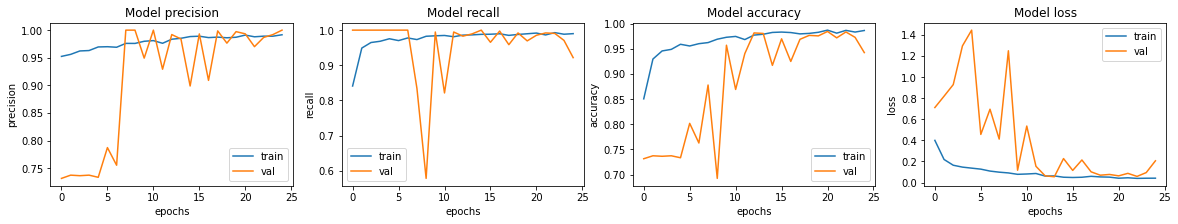

In [106]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [107]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 213ms/step - loss: 0.5646 - accuracy: 0.8750 - precision: 0.8514 - recall: 0.9692
Loss: 0.5645875334739685,
Accuracy: 0.875,
Precision: 0.8513513803482056,
Recall: 0.9692307710647583


<hr>

## 6. 성능 개선을 위한 실험

### 옵티마이저 변경

In [80]:
with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="nadam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 59s 373ms/step - loss: 0.3468 - accuracy: 0.8394 - precision: 0.9404 - recall: 0.8327 - val_loss: 0.6461 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 48s 372ms/step - loss: 0.1990 - accuracy: 0.9262 - precision: 0.9735 - recall: 0.9261 - val_loss: 0.8283 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 48s 373ms/step - loss: 0.1663 - accuracy: 0.9416 - precision: 0.9798 - recall: 0.9408 - val_loss: 1.0938 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 49s 375ms/step - loss: 0.1624 - accuracy: 0.9445 - precision: 0.9822 - recall: 0.9426 - val_loss: 1.4208 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 50s 388ms/step - loss: 0.1375 - accura

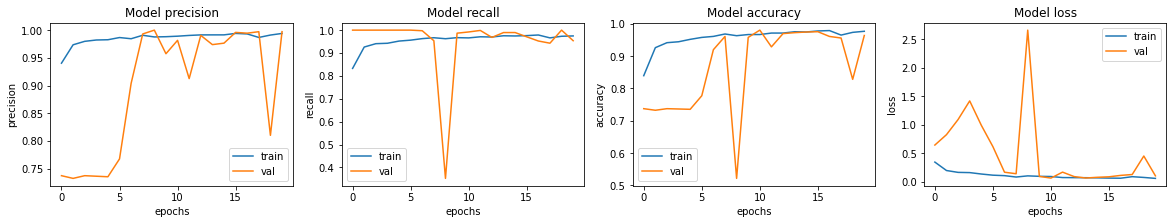

In [81]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [82]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 201ms/step - loss: 0.6475 - accuracy: 0.8397 - precision: 0.8098 - recall: 0.9718
Loss: 0.6475300192832947,
Accuracy: 0.8397436141967773,
Precision: 0.80982905626297,
Recall: 0.971794843673706


### BatchNorm X Dropout O

In [27]:
# BatchNorm 미사용 모델 설계

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)

    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [28]:
with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 56s 369ms/step - loss: 0.6948 - accuracy: 0.4286 - precision: 0.7442 - recall: 0.4255 - val_loss: 0.6961 - val_accuracy: 0.2617 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
130/130 [==============================] - 48s 371ms/step - loss: 0.6922 - accuracy: 0.4978 - precision: 0.7538 - recall: 0.4840 - val_loss: 0.6905 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 50s 386ms/step - loss: 0.6965 - accuracy: 0.5149 - precision: 0.7382 - recall: 0.5346 - val_loss: 0.6876 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 6/25
130/130 [==============================] - 53s 406ms/step - loss: 0.6919 - accuracy: 0.4820 - precision: 0.7598 - recall: 0.4444 - val_loss: 0.6943 - val_accuracy: 0.2637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/25
130/130 [==============================] - 45s 351ms/step - loss:

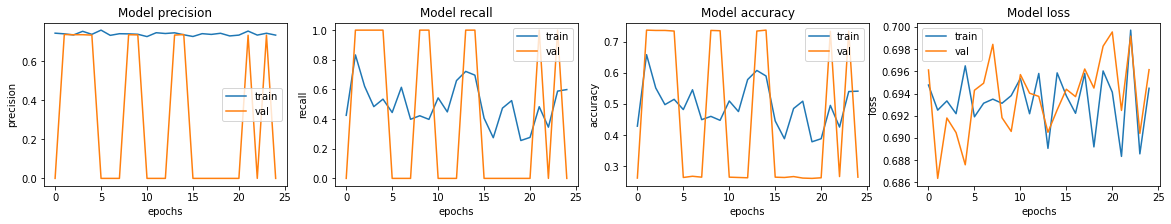

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 209ms/step - loss: 0.6948 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6947506666183472,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


### BatchNorm O Dropout X

In [31]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [32]:
with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 56s 367ms/step - loss: 0.1740 - accuracy: 0.9308 - precision: 0.9835 - recall: 0.8192 - val_loss: 0.7684 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 367ms/step - loss: 0.1205 - accuracy: 0.9579 - precision: 0.9880 - recall: 0.9550 - val_loss: 1.6696 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 47s 363ms/step - loss: 0.0929 - accuracy: 0.9649 - precision: 0.9894 - recall: 0.9632 - val_loss: 1.5229 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 48s 370ms/step - loss: 0.0700 - accuracy: 0.9750 - precision: 0.9914 - recall: 0.9748 - val_loss: 1.1903 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 46s 357ms/step - loss: 0.0438 - accura

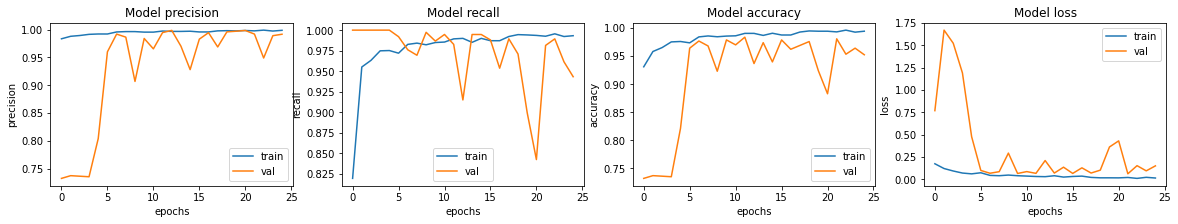

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 187ms/step - loss: 1.3506 - accuracy: 0.7628 - precision: 0.7363 - recall: 0.9667
Loss: 1.350607991218567,
Accuracy: 0.7628205418586731,
Precision: 0.736328125,
Recall: 0.9666666388511658


<hr>

## <프로젝트 회고>

이번 프로젝트에서는 모델의 성능을 개선하기 위한 여러 가지 방법들이 시도되었다. 첫 모델은 accuracy가 약 71.4%정도가 되는 모델이었다. 첫 모델치고는 성능이 좋다는 생각은 들었지만 폐렴을 진단하는 모델인 만큼 더 높은 accuracy가 요구되었다. 

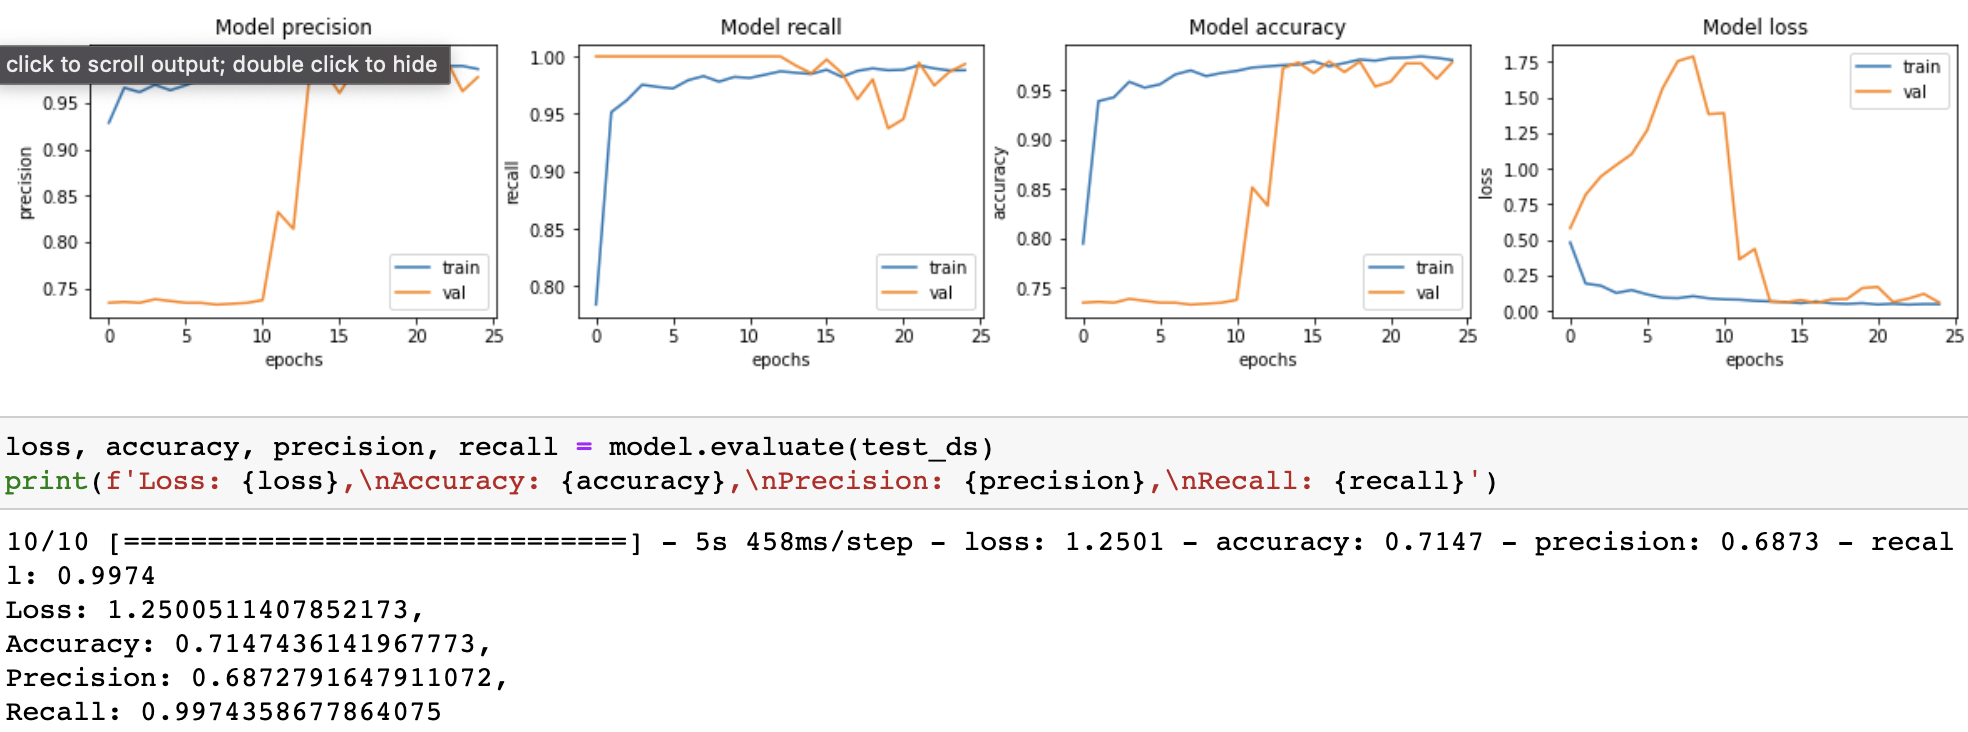

성능을 개선시키기 위한 첫 번째 방법에서 데이터 augmentation가 오히려 성능을 악화시킨다고 판단하여 제거하였고, 데이터의 imbalance문제를 해결하기 위한 class_weight를 설정해주었다. 그리고 가장 accuracy가 높게 나왔던 32로 batch_size를 설정해주었다. 그 결과, accuracy는 87.5%이었다. 

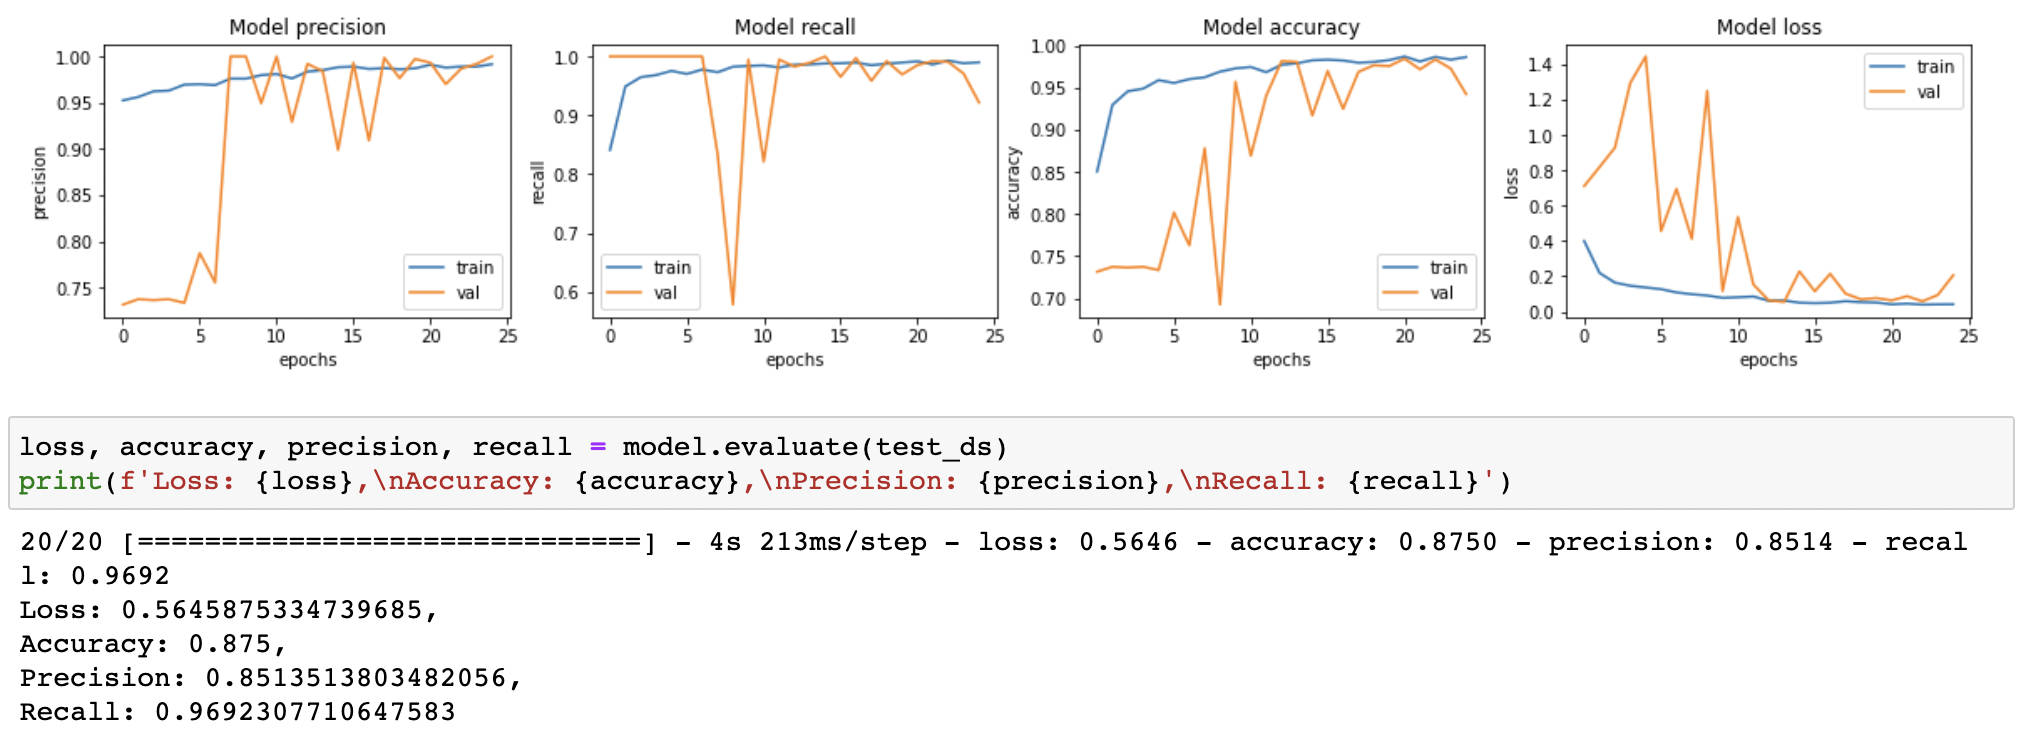

두 번째 방법으로는 모델을 훈련하면서 optimizer를 변경해주었다. 기존에 사용했던 Adam에서 Momentum 대신 NAG를 붙인 Nadam을 사용해보았다.

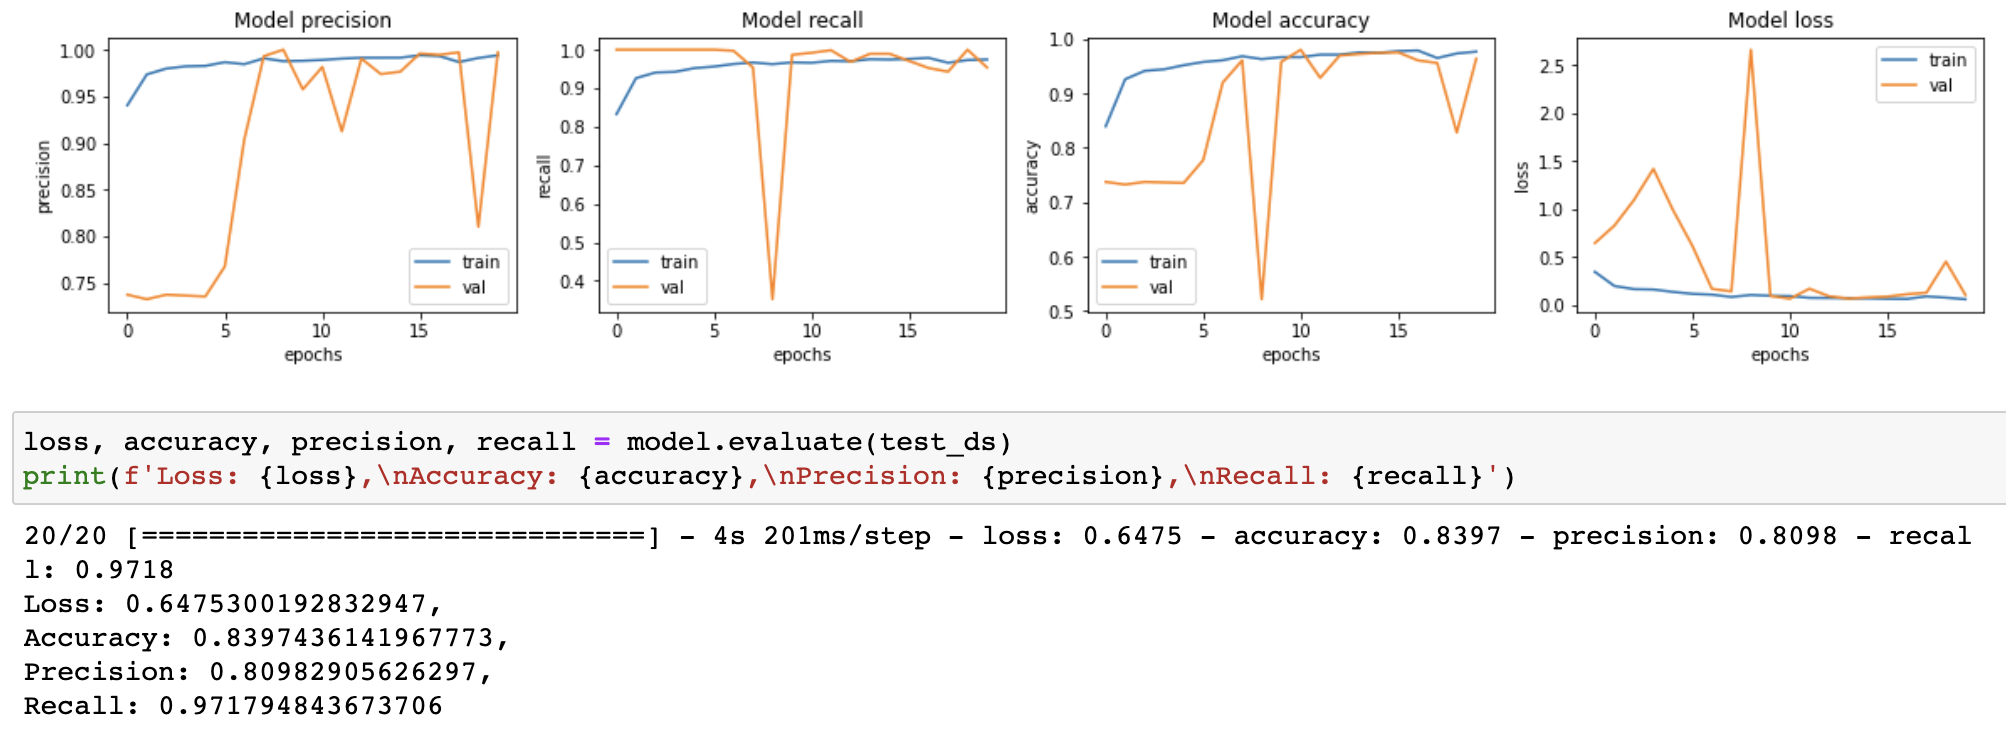

마지막 방법은 BatchNormalization과 Dropout을 사용하지 않은 모델을 비교해보는 것이었다. 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 하기 때문에 둘 다 사용을 했었다. 만약 사용을 하지 않는다면 성능에는 어떤 변화가 있을지 실험해 보았다. 그 결과, BatchNormalization과 Dropout을 둘 다 사용했을 때의 모델이 가장 성능이 좋게 나왔다.

이번 프로젝트는 모델을 설계하는 과정보다는 모델의 성능을 높이기 위해 여러 가지 방법들을 시도해볼 수 있었다. 성능을 높일 수 있는 여러 가지 방법들을 연구해보고 실험해볼 수 있는 좋은 기회였다. 앞으로 모델의 성능의 개선하는데 있어서 좋은 경험이 된 것 같다.